# YOLO, so Save Water – YOLOv4 Tiny edition

This notebook will assess the performance of YOLOv4 for detection of taps in pictures, differentiating between taps with and without running water.

This notebook is heavily based on the notebook from [Roboflow's tutorial](https://blog.roboflow.com/train-yolov4-tiny-on-custom-data-lighting-fast-detection/).

## Step 0. Setup

We will use Roboflow to manage conversion of the dataset to a format that is appropriate for Darknet. Roboflow provides a nice library of bindings for Python to easily extract the dataset.

In [ ]:
!pip install roboflow --quiet

We will also define a utility magic for IPython to write files with substitutions from Python variables:

In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

Now we will identify the GPU that Google Colab has provided and save the corresponding architecture in an environment variable to use in creation of the Makefile later.

In [ ]:
import os
from subprocess import check_output
gpu_name = check_output(['nvidia-smi', '--query-gpu=name', '--format=csv,noheader']).decode().strip()

known_architectures = {
    "Tesla V100-SXM2-16GB": "-gencode arch=compute_70,code=[sm_70,compute_70]",
    "Tesla K80": "-gencode arch=compute_37,code=sm_37",
    "Tesla T4": "-gencode arch=compute_75,code=[sm_75,compute_75]",
    "Tesla P40": "-gencode arch=compute_61,code=sm_61",
    "Tesla P4": "-gencode arch=compute_61,code=sm_61",
    "Tesla P100-PCIE-16GB": "-gencode arch=compute_60,code=sm_60"
}

os.environ['ARCH_VALUE'] = known_architectures[gpu_name]

Now we can get to compiling Darknet.

In [ ]:
%cd /content
%rm -rf darknet
!git clone https://github.com/AlexeyAB/darknet
%cd darknet

!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile
!sed -i "s/ARCH= -gencode arch=compute_60,code=sm_60/ARCH= ${ARCH_VALUE}/g" Makefile
!make

## Step 1. Configuring YOLOv4 for training on a custom dataset

First, we will fetch the pretrained weights for YOLOv4 Tiny from [the latest release of YOLOv4](https://github.com/AlexeyAB/darknet/releases/latest).

In [ ]:
%cd /content/darknet
!wget https://github.com/AlexeyAB/darknet/releases/download/yolov4/yolov4-tiny.conv.29 --quiet

Now it's time to fetch the custom dataset itself. It is available in my account in Roboflow.

**Disclaimer**: the API key in the code below is revoked, the data cannot be accessed with it.

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="3FpNhe5OoFPSZw7qdSq7")
project = rf.workspace().project("yolo--so-save-water")
dataset = project.version(1).download("darknet")

Now we will merge training and validation data together in one directory to use for training.

Our dataset will be stored at `data/obj/` and the metadata files will be `data/obj.names` and `data/obj.data`.

In [ ]:
%cp {dataset.location}/train/_darknet.labels data/obj.names
class_amount = len(open('data/obj.names').readlines())

In [ ]:
%mkdir data/obj

%cp {dataset.location}/train/*.jpg data/obj/
%cp {dataset.location}/valid/*.jpg data/obj/
%cp {dataset.location}/train/*.txt data/obj/
%cp {dataset.location}/valid/*.txt data/obj/

In [ ]:
import os

with open('data/train.txt', 'w') as out:
    for img in os.scandir(dataset.location + '/train'):
        if img.name.endswith('jpg'):
            out.write('data/obj/' + img.name + '\n')

with open('data/valid.txt', 'w') as out:
    for img in os.scandir(dataset.location + '/valid'):
        if img.name.endswith('jpg'):
            out.write('data/obj/' + img.name + '\n')

In [ ]:
%%writetemplate data/obj.data
classes = {class_amount}
train = data/train.txt
valid = data/valid.txt
names = data/obj.names
backup = backup/

Now we will write the configuration for the YOLO architecture, customizing certain values as described in the steps to training on a custom dataset in the README of Darknet.

In [ ]:
max_batches = max(class_amount * 2000, 6000)
steps = f'{int(.8 * max_batches)},{int(.9 * max_batches)}'
filter_amount = (class_amount + 5) * 3

The configuration below is based on [`darknet/cfg/yolov4-tiny.cfg`](https://github.com/AlexeyAB/darknet/blob/master/cfg/yolov4-tiny.cfg)

In [ ]:
%%writetemplate ./cfg/custom-yolov4-tiny-detector.cfg
[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=24
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00261
burn_in=1000
max_batches = {max_batches}
policy=steps
steps={steps}
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

##################################

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={filter_amount}
activation=linear



[yolo]
mask = 3,4,5
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes={class_amount}
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
resize=1.5
nms_kind=greedynms
beta_nms=0.6

[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 23

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={filter_amount}
activation=linear

[yolo]
mask = 1,2,3
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes={class_amount}
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
resize=1.5
nms_kind=greedynms
beta_nms=0.6

## Step 2. Training

In [ ]:
!./darknet detector train data/obj.data cfg/custom-yolov4-tiny-detector.cfg yolov4-tiny.conv.29 -dont_show -map

## Step 3. Inference

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def show_image(path):
    image = cv2.imread(path)
    height, width = image.shape[:2]
    resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
#coco.names is hardcoded somewhere in the detector
%cp data/obj.names data/coco.names

In [ ]:
!pwd

In [ ]:
import random
test_images = [f for f in os.listdir(os.path.join(dataset.location, 'test')) if f.endswith('.jpg')]
img_path = os.path.join(dataset.location, "test", random.choice(test_images))

#test out our detector!
!./darknet detect cfg/custom-yolov4-tiny-detector.cfg backup/custom-yolov4-tiny-detector_best.weights {img_path} -dont-show
show_image('/content/darknet/predictions.jpg')

## Step 4. Metrics & Analysis

Darknet has plotted a chart of the loss and mAP during training, presented below:

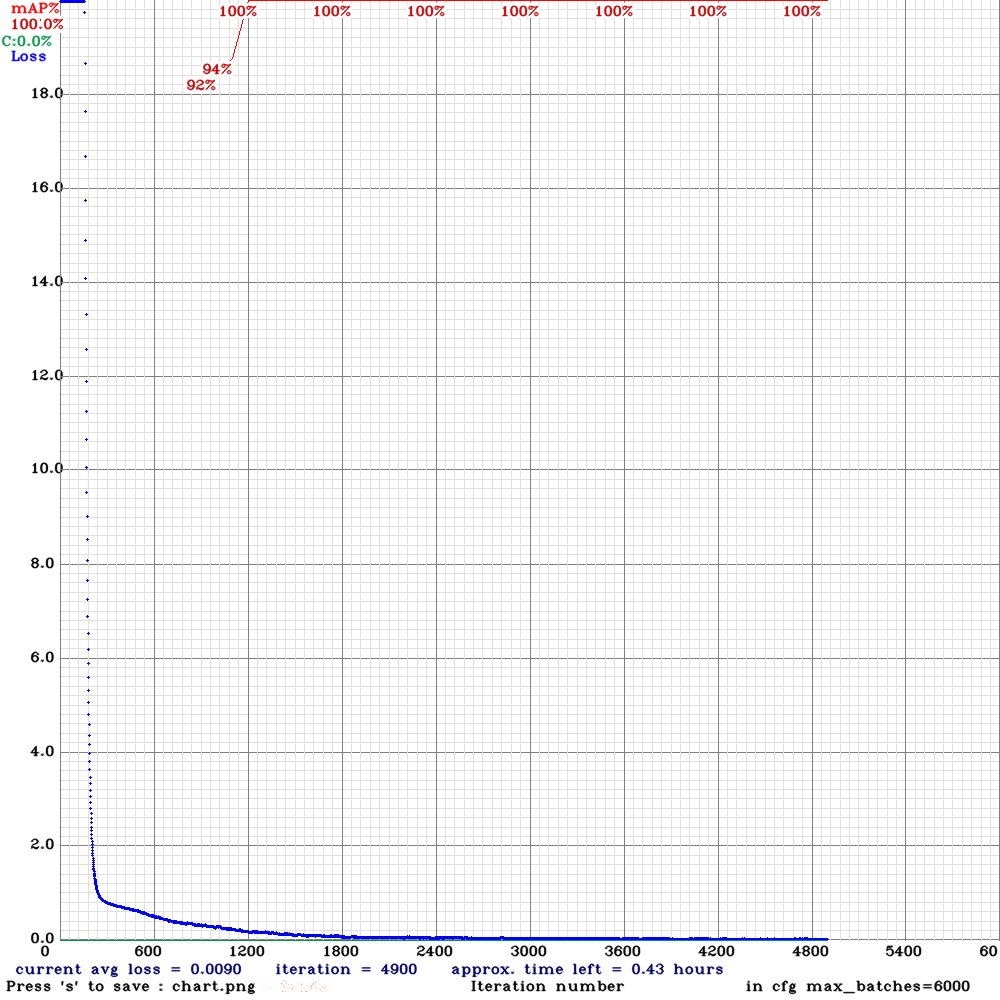

According to this chart, mAP has reached 100%, which is surprising, considering that in the inference stage, there are some mispredictions. 